# Code for plotting the correlation for each parameter

Loading data...
Getting wind speed...
Checking for missing values...
Found NaN value at 2019-01-07T23:00:00Z. Removing from both datasets.
Found NaN value at 2019-01-07T23:00:00Z. Removing from both datasets.
Found NaN value at 2019-01-07T23:00:00Z. Removing from both datasets.
Found NaN value at 2019-01-07T23:00:00Z. Removing from both datasets.


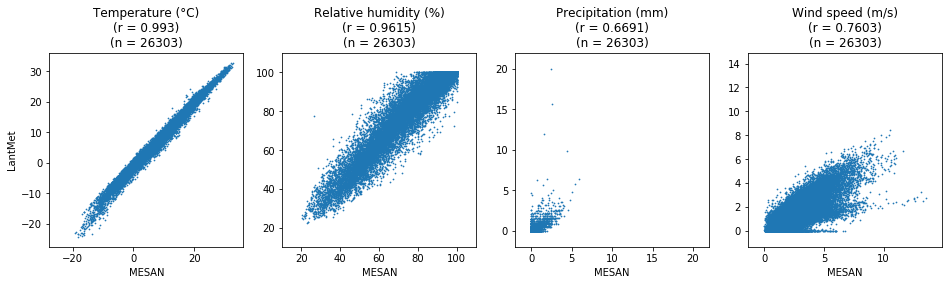

In [4]:
from METCOMP_utils import *
import matplotlib.pyplot as plt
import datetime
from scipy.stats import pearsonr
import numpy as np
import pandas as pd

start_date = datetime.date(2017, 3, 1)
end_date = datetime.date(2020, 2, 29)
params = ['TM', 'UM', 'RR', 'FM2']

print('Loading data...')
df_MESAN = read_CSV('40010', 'MESAN', start_date, end_date)
df_LANTMET = get_LANTMET('40010', start_date, end_date)

print('Getting wind speed...')
MESAN_ws = np.sqrt(np.square(df_MESAN['u_sfc']) + np.square(df_MESAN['v_sfc']))
df_MESAN['ws_sfc'] = MESAN_ws

param_dict = {'TM': 't_sfc', 'RR': 'prec1h_sfc', 'UM': 'r_sfc', 'FM2': 'ws_sfc'}
param_title = {'TM': 'Temperature (°C)', 'RR': 'Precipitation (mm)', 'UM': 'Relative humidity (%)', 'FM2': 'Wind speed (m/s)'}

# Unit conversion.
df_MESAN[param_dict['TM']] = df_MESAN[param_dict['TM']] - 273.15
df_MESAN[param_dict['UM']] = df_MESAN[param_dict['UM']]*100

# Check for missing values. Remove from both datasets.
print('Checking for missing values...')
bad_rows = {}
for param in params:
    bad_MESAN = df_MESAN[df_MESAN[param_dict[param]].isnull()]
    bad_LANTMET = df_LANTMET[df_LANTMET[param].isnull()]
    # Find rows
    for index, df_row in bad_MESAN.iterrows():
        bad_rows[df_row['Timestamp']] = None
    for index, df_row in bad_LANTMET.iterrows():
        bad_rows[df_row['Timestamp']] = None
    # Remove rows.
    for bad_row in bad_rows:
        print('Found NaN value at ' + bad_row + '. Removing from both datasets.', end='\n')
        df_MESAN = df_MESAN[~df_MESAN['Timestamp'].str.contains(bad_row)]
        df_LANTMET = df_LANTMET[~df_LANTMET['Timestamp'].str.contains(bad_row)]


fig, axs = plt.subplots(1, len(params), figsize=(16, 16))
index = 0
scale = 1.1
for param in params:
    
    limits = [max(df_MESAN[param_dict[param]]), min(df_MESAN[param_dict[param]]), max(df_LANTMET[param]), min(df_LANTMET[param])]
    limits = [min(limits) - (scale-1)*max(limits), max(limits)*scale]
    
    # Get pearson correlation coefficient.
    n = df_MESAN.shape[0]
    
    r = round(pearsonr(df_MESAN[param_dict[param]].to_numpy(), df_LANTMET[param].to_numpy())[0], 4)
        
    # Scatter datapoints and get confidence ellipse.
    axs[index].scatter(df_MESAN[param_dict[param]].to_numpy(), df_LANTMET[param].to_numpy(), s=0.5)
    #confidence_ellipse(df_MESAN[param_dict[param]].to_numpy(), df_LANTMET[param].to_numpy(), axs[index], n_std=4, label=r'$4\sigma$', edgecolor=(1, 0.0, 0), linestyle = '--')
    #axs[index].legend()
    
    # Set labels
    if index == 0:
        axs[index].set_ylabel('LantMet')
    axs[index].set_xlabel('MESAN')
        
    # Set aspects.
    axs[index].set_xlim(limits)
    axs[index].set_ylim(limits)
    x0,x1 = axs[index].get_xlim()
    y0,y1 = axs[index].get_ylim()
    axs[index].set_aspect(abs(x1-x0)/abs(y1-y0))
        
    # Set subplot title to month name and include pearson correlation coefficient.
    axs[index].title.set_text(param_title[param] + '\n(r = ' + str(r) + ')\n(n = ' + str(n) + ')' )
    
    index = index + 1

# Uncomment this line to save the figure
#fig.savefig('correlation.pdf')